In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import itertools
import laplace
from laplace import Laplace
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import csv
from pathlib import Path
from scipy.stats import pearsonr
import numpy as np

import torch.nn as nn
import matplotlib.pyplot as plt

import uncertainties.uncertainties as unc
import dataloaders as dl
import models as m

import inspect
import samplers

/home/johnny/.virtualenvs/jup/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def entropy(x, eps=0.00000000000000000001):
    return -x*np.log2(x+eps) - (1-x)*np.log2(1-x+eps)

def ds(dataset, batch_size=20):
    return DataLoader(TensorDataset(torch.Tensor(dataset[0]), torch.LongTensor(dataset[1])),
                      batch_size=batch_size)
def generate_mlp(input_size: int, cfg= None, initial_dropout=0.5, output_layer="softmax"):
    if cfg is None:
        cfg = [256, 512, 256, 2]
    layers = [
        nn.Flatten(),
        nn.Linear(input_size, cfg[0]),
        nn.ReLU(),
        nn.Dropout(initial_dropout)
    ]
    if len(cfg) > 1:
        for w1, w2 in zip(cfg[:-2], cfg[1:-1]):
            layers += [nn.Linear(w1, w2), nn.ReLU(),nn.Dropout(initial_dropout)]
    layers += [nn.Linear(cfg[-2], cfg[-1])]
    model = nn.Sequential(*layers)
    model.d = sum(cfg[i] * cfg[i + 1] for i in range(len(cfg) - 1))
    
    return model

def get_data2(num, test_num,p=0):
    contextual, noncontextual = samplers.prepare_mixed_states_from_10D_saved(
        num, num, train=True
    )
    contextual_test, noncontextual_test = samplers.prepare_mixed_states_from_10D_saved(
        test_num, test_num, train=False
    )
    idxs = np.random.permutation(2*num)
    
    training_data = [np.concatenate([contextual, noncontextual])[idxs],
                     np.concatenate([np.random.choice([0,1],num, True, [1-p,p]), np.random.choice([0,1],num, True, [p,1-p])])[idxs]]

    test_data = [np.concatenate([contextual_test, noncontextual_test]),
                 np.concatenate([np.zeros(test_num), np.ones(test_num)])]
        

    return training_data, test_data

def experiment(train_dataset, test_dataset, results, architecture, num):
    m_normal = generate_mlp(20, architecture, initial_dropout=0)
    m_mcmc = generate_mlp(20, architecture, initial_dropout=0)
    train_dl = ds(train_dataset)
    test_dl = ds(test_dataset)
    
    c1 = m.Classifier(train_dl, test_dl, m_normal)
    c1.train_and_eval(alpha=0)
    
    preds = c1.pred(test_dl)[0]
    preds_int = (preds>0.5).astype(int)
    entropy_normal = entropy(preds)
    acc = np.mean(preds_int  == test_dataset[1])

    hmc_preds = unc.get_HMC_preds(
            train_data = train_dataset,
            net = m_mcmc,
            test_data = test_dataset,
            device = 'cpu',
            num_samples = 15000,
            L=10,
            tau=1)

    preds_mcmc = np.mean(hmc_preds, axis=0)
    preds_mcmc_int = ((preds_mcmc>0.5).astype(int) + 1)%2
    acc_mcmc = np.mean(preds_mcmc_int == test_dataset[1])
    entropy_mcmc = entropy(preds_mcmc)
    results.append([num, acc, acc_mcmc])
    print("MCMC: ", acc_mcmc, "STANDARD: ", acc)

def exp(nums=[50, 200, 500], architecture=[128, 64, 32, 8, 2], path="default",p=0):
    results = []
    train_dataloader_full, test_dataloader = get_data2(1000,2000,p)
    for idx, i in enumerate(nums):
        train_dataset = [x[:i] for x in train_dataloader_full]
        experiment(train_dataset, test_dataloader, results, architecture, i)
    
    path = "results_contextuality/contextuality_" + path
    Path(path).mkdir(parents=True, exist_ok=True)
    plt.scatter(nums, [r[1] for r in results], color="red")
    plt.scatter(nums, [r[2] for r in results], color="blue")
    plt.savefig(f"{path}/plot_{architecture}.png")

    plt.show()
    
    with open(f'{path}/acc_results.csv', 'w') as file:
        writer = csv.writer(file)
        writer.writerow(["num", "Standard", "MCMC"])
        [writer.writerow(r) for r in results]

In [3]:
nums=[50]*5+[100]*5+[150]*5+[200]*5+[250]*5+[400]*5

In [4]:
nums = [20, 30, 40, 50, 60, 100, 150, 200, 250, 300, 350, 400]

In [5]:
exp(nums=nums, architecture=[64, 32, 8, 2], path="e63-32-8-2_01",p=0.01)

Classifier training has finished with acc: 1.000
Test acc: 0.588
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.011462152935564518-- |    92/15000 | 51.49       


KeyboardInterrupt: 

In [ ]:
exp(nums=nums, architecture=[128, 64, 32, 8, 2], path="e128_64_32_8_2_01", p=0.01)

In [ ]:
exp(nums=nums, architecture=[32, 8, 2], path="e32_8_2")

In [11]:
import pandas as pd
path = "/home/johnny/PycharmProjects/Contextuality-classification-with-uncertainty-estimation/results_contextuality/L=10-25000/contextuality_128_64_32_8_2/acc_results.csv"
df = pd.read_csv(path, sep=',', header=0)

path2 = "/home/johnny/PycharmProjects/Contextuality-classification-with-uncertainty-estimation/results_contextuality/L=10-25000/contextuality_64_32_8_2/acc_results.csv"
df2 = pd.read_csv(path2, sep=',', header=0)

path3 = "/home/johnny/PycharmProjects/Contextuality-classification-with-uncertainty-estimation/results_contextuality/L=10-25000/contextuality_32_8_2/acc_results.csv"
df3 = pd.read_csv(path3, sep=',', header=0)


In [12]:
df = df[df["num"]!=60]
df2 = df2[df2["num"]!=60]
df3 = df3[df3["num"]!=60]

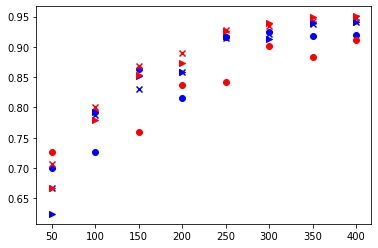

In [17]:
plt.scatter(df["num"], df["Standard"], c='blue', label = "NN")
plt.scatter(df["num"], df["MCMC"], c='red', label = "BNN")
plt.scatter(df2["num"], df2["Standard"], c='blue', label = "NN", marker = "x")
plt.scatter(df2["num"], df2["MCMC"], c='red', label = "BNN", marker = "x")
plt.scatter(df3["num"], df3["Standard"], c='blue', label = "NN", marker = ">")
plt.scatter(df3["num"], df3["MCMC"], c='red', label = "BNN", marker = ">")


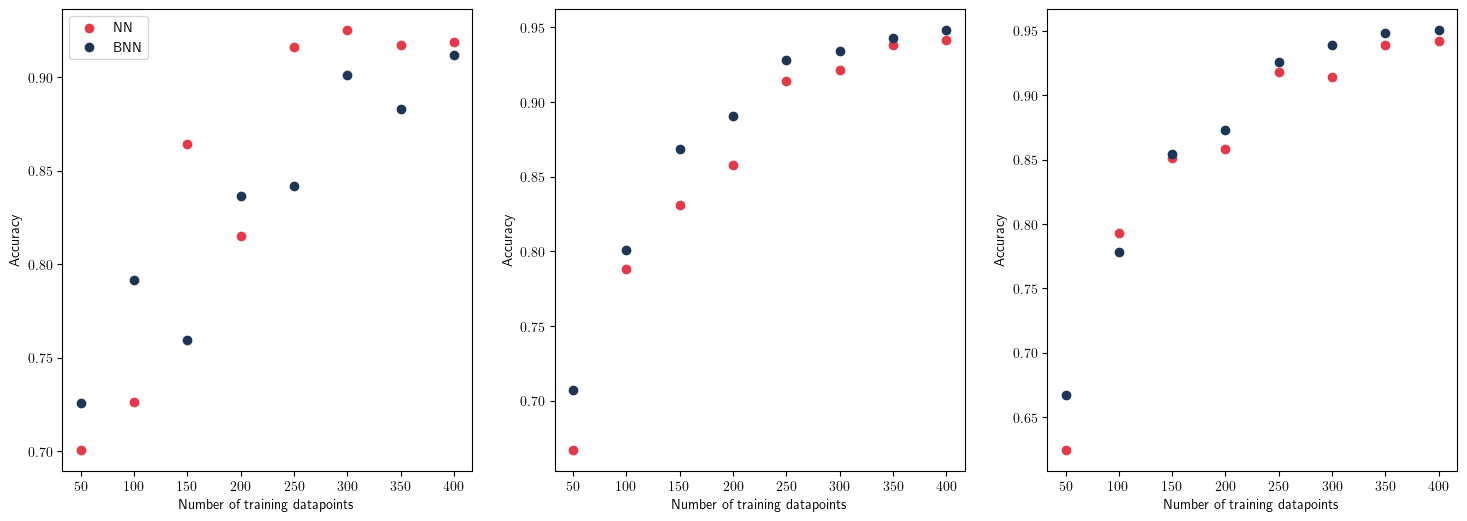

In [96]:
a = NN_COLOR
b = BNN_COLOR
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(18,6))
ax1.scatter(df["num"], df["Standard"], c=a, label = "NN")
ax1.scatter(df["num"], df["MCMC"], c=b, label = "BNN")
ax1.set_xlabel("Number of training datapoints")
ax1.set_ylabel("Accuracy")
ax2.scatter(df2["num"], df2["Standard"], c=a)
ax2.scatter(df2["num"], df2["MCMC"], c=b)
ax2.set_xlabel("Number of training datapoints")
ax2.set_ylabel("Accuracy")
ax3.scatter(df3["num"], df3["Standard"], c=a)
ax3.scatter(df3["num"], df3["MCMC"], c=b)
ax3.set_xlabel("Number of training datapoints")
ax3.set_ylabel("Accuracy")
ax1.legend()

In [6]:
num=150
train_dataset, test_dataset = get_data2(num,2000,0)
architecture=[64, 32, 8, 2]

In [7]:
results=[]
m_normal = generate_mlp(20, architecture, initial_dropout=0)
m_mcmc = generate_mlp(20, architecture, initial_dropout=0)
train_dl = ds(train_dataset)
test_dl = ds(test_dataset)

c1 = m.Classifier(train_dl, test_dl, m_normal)
c1.train_and_eval(alpha=0)

preds = c1.pred(test_dl)[0]
preds_int = (preds>0.5).astype(int)
entropy_normal = entropy(preds)
acc = np.mean(preds_int  == test_dataset[1])

hmc_preds = unc.get_HMC_preds(
        train_data = train_dataset,
        net = m_mcmc,
        test_data = test_dataset,
        device = 'cpu',
        num_samples = 15000,
        L=10,
        tau=1)

preds_mcmc = np.mean(hmc_preds, axis=0)
aleo = np.mean(entropy(hmc_preds), axis=0)
preds_mcmc_int = ((preds_mcmc>0.5).astype(int) + 1)%2
acc_mcmc = np.mean(preds_mcmc_int == test_dataset[1])
entropy_mcmc = entropy(preds_mcmc)
entropy_nn = entropy(preds)

results.append([num, acc, acc_mcmc])
print("MCMC: ", acc_mcmc, "STANDARD: ", acc)


Classifier training has finished with acc: 1.000
Test acc: 0.932
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
Final Adapted Step Size:  0.005014330148696899-- |    97/15000 | 46.06       
0d:00:04:13 | 0d:00:00:00 | #################### | 15000/15000 | 59.11       
Acceptance Rate 0.46
MCMC:  0.934 STANDARD:  0.932


In [9]:
aleo = np.mean(entropy(hmc_preds), axis=0)


(array([1302.,  619.,  494.,  477.,  440.,  354.,  196.,   94.,   17.,
           7.]),
 array([3.66755017e-07, 2.36830842e-02, 4.73657995e-02, 7.10485205e-02,
        9.47312340e-02, 1.18413955e-01, 1.42096668e-01, 1.65779382e-01,
        1.89462110e-01, 2.13144824e-01, 2.36827537e-01]),
 <BarContainer object of 10 artists>)

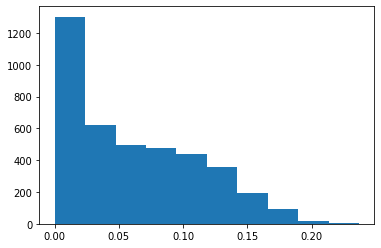

In [10]:
plt.hist(aleo)

In [11]:
epi_bad = entropy_mcmc[preds_mcmc_int != test_dataset[1]] - aleo[preds_mcmc_int != test_dataset[1]]
epi = entropy_mcmc - aleo
ent_bad = entropy_mcmc[preds_mcmc_int != test_dataset[1]]
ent_nn_bad = entropy_nn[preds_int != test_dataset[1]]

In [12]:
len(ent_bad)

264

In [34]:
def u(alpha):
    return len(ent_nn_bad[ent_nn_bad > alpha])/len(entropy_nn[entropy_nn > alpha])
def u2(alpha):
    return len(epi_bad[epi_bad > alpha])/(len(epi[epi>alpha])) if len(epi_bad[epi_bad > alpha]) else None 
def u3(alpha):
    return len(ent_bad[ent_bad > alpha])/(len(entropy_mcmc[entropy_mcmc > alpha])+1)

def u4(alpha):
    return len(ent_nn_bad[ent_nn_bad > alpha])/len(ent_nn_bad)
def u5(alpha):
    return len(epi_bad[epi_bad > alpha])/len(epi_bad)
def u6(alpha):
    return len(ent_bad[ent_bad > alpha])/len(epi_bad)

In [37]:
def u_(alpha):
    return len(ent_nn_bad[ent_nn_bad < alpha])/len(entropy_nn[entropy_nn < alpha]) if len(entropy_nn[entropy_nn < alpha]) else None
def u2_(alpha):
    return len(epi_bad[epi_bad < alpha])/len(epi[epi<alpha]) if len(epi_bad[epi_bad < alpha]) else None 
def u3_(alpha):
    return len(ent_bad[ent_bad < alpha])/len(entropy_mcmc[entropy_mcmc < alpha]) if len(entropy_mcmc[entropy_mcmc < alpha]) else None

In [20]:
xx = np.arange(0,1,0.01)

Text(0, 0.5, '$P($Missclasification $|$ Unccertainty $ > \\alpha)$')

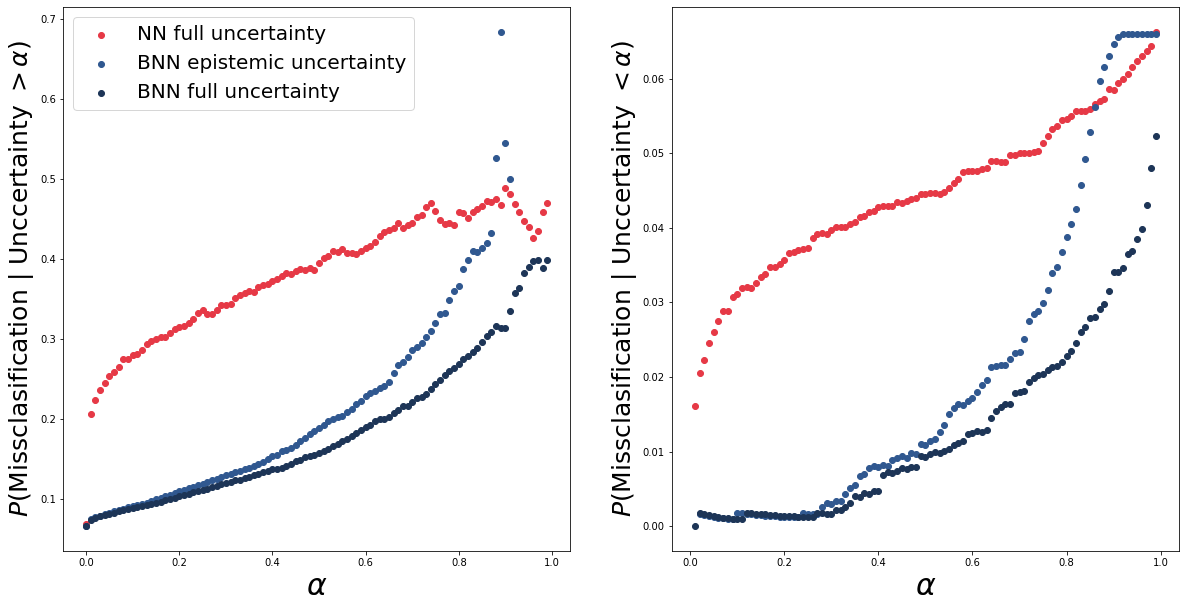

In [50]:
NN_COLOR = '#e63946'
BNN_COLOR =  '#1d3557'
BNN_COLOR2 =  '#305890'
fig, (ax2, ax1) = plt.subplots(1,2 , figsize = (20,10))
ax1.scatter(xx, list(map(u_, xx)), color = NN_COLOR, label = "NN full uncertainty")
ax1.scatter(xx, list(map(u2_, xx)), color = BNN_COLOR2, label = "BNN epistemic uncertainty")
ax1.scatter(xx, list(map(u3_, xx)), color = BNN_COLOR, label = "BNN full uncertainty")
#ax1.legend(fontsize="x-large")
ax1.set_xlabel(r"$\alpha$", fontsize=30)
ax1.set_ylabel(r"$P($Missclasification $|$ Unccertainty $ < \alpha)$", fontsize=25)

ax2.scatter(xx, list(map(u, xx)), color = NN_COLOR, label = "NN full uncertainty")
ax2.scatter(xx, list(map(u2, xx)), color = BNN_COLOR2, label = "BNN epistemic uncertainty")
ax2.scatter(xx, list(map(u3, xx)), color = BNN_COLOR, label = "BNN full uncertainty")
ax2.legend(fontsize=20)
ax2.set_xlabel(r"$\alpha$", fontsize=30)
ax2.set_ylabel(r"$P($Missclasification $|$ Unccertainty $ > \alpha)$", fontsize=25)

Text(0, 0.5, '$P($Missclasification $|$ Unccertainty $ > \\alpha)$')

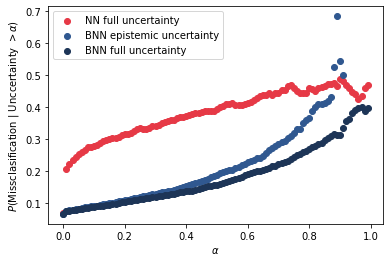

In [36]:
NN_COLOR = '#e63946'
BNN_COLOR =  '#1d3557'
BNN_COLOR2 =  '#305890'

plt.scatter(xx, list(map(u, xx)), color = NN_COLOR, label = "NN full uncertainty")
plt.scatter(xx, list(map(u2, xx)), color = BNN_COLOR2, label = "BNN epistemic uncertainty")
plt.scatter(xx, list(map(u3, xx)), color = BNN_COLOR, label = "BNN full uncertainty")
plt.legend()
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$P($Missclasification $|$ Unccertainty $ > \alpha)$")

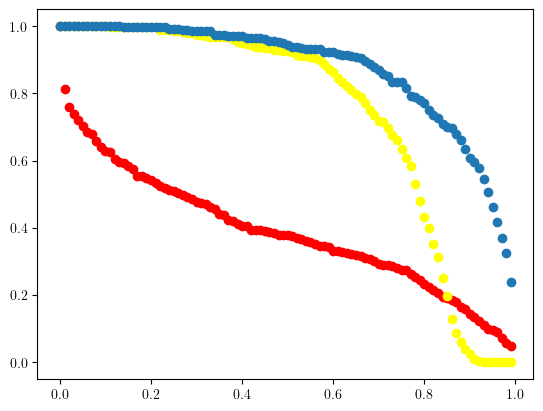

In [67]:
plt.scatter(xx, list(map(u4, xx)), color="red")
plt.scatter(xx, list(map(u5, xx)), color = "yellow")
plt.scatter(xx, list(map(u6, xx)))

(array([  2.,   5.,   6.,   5.,   7.,   5.,  23.,  41.,  73., 118.]),
 array([0.01258486, 0.10381736, 0.19504985, 0.28628236, 0.37751484,
        0.46874735, 0.55997986, 0.65121233, 0.7424448 , 0.83367735,
        0.92490983], dtype=float32),
 <BarContainer object of 10 artists>)

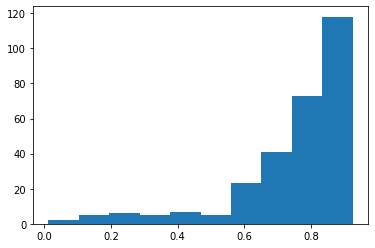

In [23]:
plt.hist(entropy_mcmc[preds_mcmc_int != test_dataset[1]] - aleo[preds_mcmc_int != test_dataset[1]])

(array([1037.,  451.,  401.,  349.,  323.,  281.,  315.,  281.,  297.,
         265.]),
 array([3.5024459e-05, 9.2522502e-02, 1.8500999e-01, 2.7749747e-01,
        3.6998495e-01, 4.6247244e-01, 5.5495989e-01, 6.4744741e-01,
        7.3993486e-01, 8.3242238e-01, 9.2490983e-01], dtype=float32),
 <BarContainer object of 10 artists>)

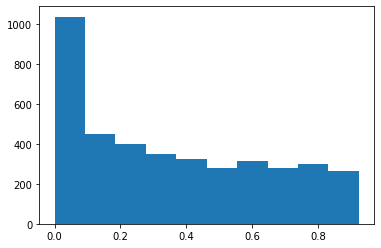

In [24]:
plt.hist(entropy_mcmc-aleo)

(array([1032.,  441.,  396.,  337.,  320.,  267.,  301.,  241.,  221.,
         159.]),
 array([3.5024459e-05, 9.1825806e-02, 1.8361658e-01, 2.7540737e-01,
        3.6719814e-01, 4.5898893e-01, 5.5077970e-01, 6.4257050e-01,
        7.3436129e-01, 8.2615203e-01, 9.1794282e-01], dtype=float32),
 <BarContainer object of 10 artists>)

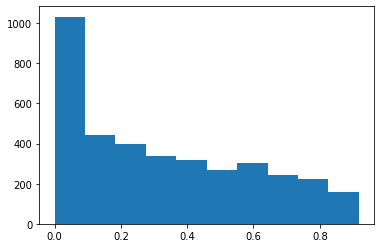

In [25]:
plt.hist(entropy_mcmc[preds_mcmc_int == test_dataset[1]] - aleo[preds_mcmc_int == test_dataset[1]])

(array([907., 427., 394., 333., 277., 307., 276., 268., 293., 518.]),
 array([8.0470741e-08, 1.0000006e-01, 2.0000005e-01, 3.0000001e-01,
        4.0000001e-01, 4.9999997e-01, 5.9999996e-01, 6.9999993e-01,
        7.9999989e-01, 8.9999992e-01, 9.9999988e-01], dtype=float32),
 <BarContainer object of 10 artists>)

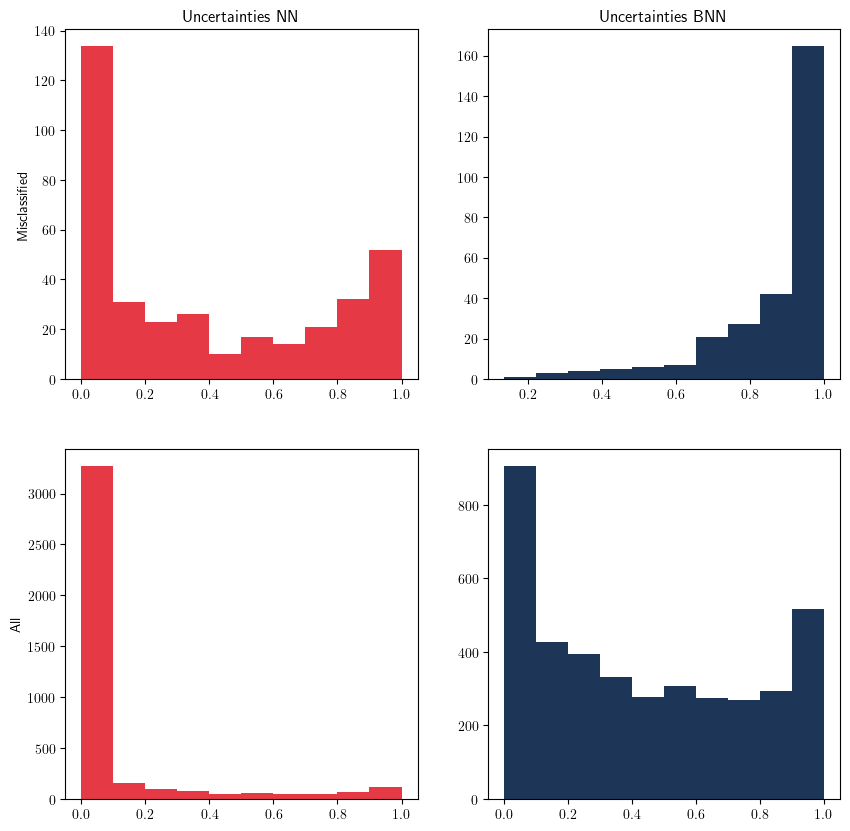

In [95]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.hist(entropy_nn[preds_int != test_dataset[1]], color=NN_COLOR)
ax1.title.set_text("Uncertainties NN")
ax1.set_ylabel("Misclassified")
ax2.hist(entropy_mcmc[preds_mcmc_int != test_dataset[1]], color=BNN_COLOR)
ax2.title.set_text("Uncertainties BNN")
ax3.hist(entropy_nn, color=NN_COLOR)
ax3.set_ylabel("All")

#ax3.axis(ymax=3200)
ax4.hist(entropy_mcmc, color=BNN_COLOR)
#ax4.axis(ymax=3200)

(array([1037.,  451.,  401.,  349.,  323.,  281.,  315.,  281.,  297.,
         265.]),
 array([3.5024459e-05, 9.2522502e-02, 1.8500999e-01, 2.7749747e-01,
        3.6998495e-01, 4.6247244e-01, 5.5495989e-01, 6.4744741e-01,
        7.3993486e-01, 8.3242238e-01, 9.2490983e-01], dtype=float32),
 <BarContainer object of 10 artists>)

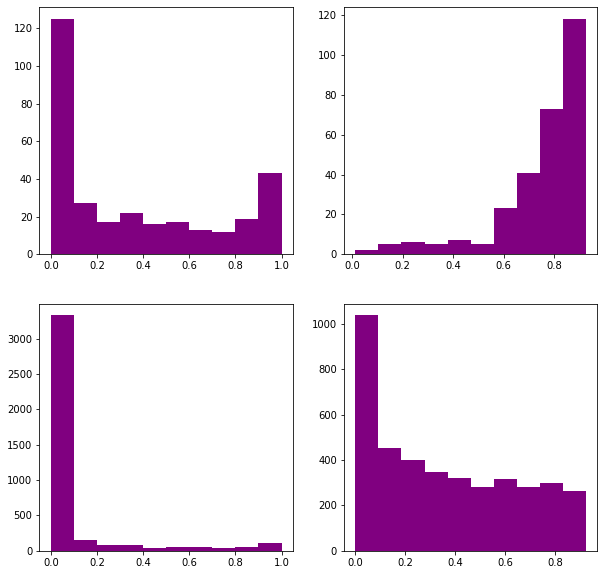

In [59]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.hist(entropy_nn[preds_int != test_dataset[1]], color='purple')
#ax1.axis(ymax=200)
ax2.hist(epi[preds_mcmc_int != test_dataset[1]], color='purple')
#ax2.axis(ymax=200)
ax3.hist(entropy_nn, color='purple')
#ax3.axis(ymax=3200)
ax4.hist(epi, color='purple')
#ax4.axis(ymax=3200)

In [22]:
path2 = "/home/johnny/PycharmProjects/Contextuality-classification-with-uncertainty-estimation/results_contextuality/L=10-25000/contextuality_64_32_8_2/acc_results.csv"
df2 = pd.read_csv(path2, sep=',', header=0)

In [ ]:
num	Standard	MCMC
50	0.667	0.70725
60	0.75375	0.74075
100	0.788	0.80075
150	0.83075	0.86875
200	0.85775	0.89025
250	0.914	0.92825
300	0.92125	0.934
350	0.93775	0.94275
400	0.94125	0.948


In [3]:

def get_HMC_preds(
        dataloader_tr,
        dataloader_val,
        net = generate_mlp(2, [128,64,32, 8, 2]),
        device = 'cuda:0'
):

    step_size = 0.003
    num_samples = 15000
    L = 1
    burn = 5000
    store_on_GPU = False
    debug = False
    model_loss = 'multi_class'
    mass = 1.0

    # Effect of tau
    # Set to tau = 1000. to see a function that is less bendy (weights restricted to small bends)
    # Set to tau = 1. for more flexible

    tau = 1.0 # Prior Precision
    r = 0 # Random seed


    tau_list = []
    for w in net.parameters():
        tau_list.append(tau) # set the prior precision to be the same for each set of weights
    tau_list = torch.tensor(tau_list).to(device)

    # Set initial weights
    params_init = hamiltorch.util.flatten(net).to(device).clone()
    # Set the Inverse of the Mass matrix
    inv_mass = torch.ones(params_init.shape) / mass

    integrator = hamiltorch.Integrator.SPLITTING
    sampler = hamiltorch.Sampler.HMC

    hamiltorch.set_random_seed(r)
    params_hmc_f = hamiltorch.sample_split_model(net, dataloader_tr, params_init=params_init,
                                           model_loss=model_loss, num_samples=num_samples,
                                           burn = burn, inv_mass=inv_mass.to(device),step_size=step_size,
                                           num_steps_per_sample=L, tau_list=tau_list,
                                           debug=debug, store_on_GPU=store_on_GPU,
                                           sampler = sampler, num_splits=20)
    
    # At the moment, params_hmc_f is on the CPU so we move to GPU

    params_hmc_gpu = [ll.to(device) for ll in params_hmc_f[1:]]
    X_test = torch.FloatTensor(X_test)
    Y_test = torch.FloatTensor(Y_test)

    # Let's predict over the entire test range [-2,2]
    pred_list, log_probs_f = hamiltorch.predict_model(net,
                                                      dataloader_val,
                                                      samples=params_hmc_gpu,
                                                      model_loss=model_loss,
                                                      tau_list=tau_list
                                                     )

    s = nn.Softmax(dim=2)
    return s(pred_list)[:,:, 0]

In [3]:
net = generate_mlp(20, [128,64,32,16, 1])

# Effect of tau
# Set to tau = 1000. to see a function that is less bendy (weights restricted to small bends)
# Set to tau = 1. for more flexible
def train_hmc(net, dataloader_tr, dataloader_val):
    step_size = 0.003
    L = 5
    mass = 1.0
    tau = 1.0 # Prior Precision

    num_samples = 25000
    burn = 5000
    store_on_GPU = False
    debug = False
    model_loss = 'binary_class_linear_output'

    tau_list = torch.tensor([tau for _ in net.parameters()]).to(device)
    sampler = hamiltorch.Sampler.HMC
    params_init = hamiltorch.util.flatten(net).to(device).clone()
    inv_mass = torch.ones(params_init.shape) / mass
    device = "cuda:0"
    hamiltorch.set_random_seed(0)
    integrator = hamiltorch.Integrator.SPLITTING # Here we select the default splitting scheme




    hamiltorch.set_random_seed(0)
    # Note the second parameter is now dataLoader_tr
    params_hmc_s = hamiltorch.sample_split_model(net, dataloader_tr, params_init=params_init,
                                                 num_splits=4, num_samples=num_samples,
                                                 step_size=step_size, num_steps_per_sample=L,
                                                 inv_mass = inv_mass.to(device), integrator=integrator,
                                                 debug = debug, store_on_GPU=store_on_GPU, burn = burn,
                                                 sampler = sampler, tau_list=tau_list, model_loss=model_loss)



In [4]:
def acc(y_hat, y):
    preds_int = (y_hat > 0).int().numpy()
    return np.sum(np.equal(y.numpy(), preds_int))

In [5]:
def train_classical(net, dataloader_tr, datasoader_val, act = "sigmoid", epochs=200):
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
    criterion = torch.nn.BCEWithLogitsLoss() if act == 'sigmoid' else torch.nn.torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        acc_train_epoch = 0
        for X,y in dataloader_tr:
            optimizer.zero_grad()
            y_hat = net(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            acc_train_epoch += acc(y_hat, y)
        if epoch%40==0:
            print(f"acc epoch {epoch} = {acc_train_epoch/len(dataloader_tr)}")
    
    acc_test = 0
    for X, y in dataloader_val:
        y_hat = net(X)
        acc_test += acc(y_hat, y) 
    
    acc_train_epoch /= len(dataloader_tr.dataset)
    acc_test /= len(dataloader_val.dataset)
    return acc_train_epoch, acc_test

In [6]:
num=100
test_num = 10000
batch_size=2000
def get_data(num, test_num, batch_size):
    contextual, noncontextual = samplers.prepare_mixed_states_from_10D_saved(
        num, num, train=True
    )
    contextual_test, noncontextual_test = samplers.prepare_mixed_states_from_10D_saved(
        test_num, test_num, train=False
    )

    training_data = TensorDataset(
        torch.concat((torch.FloatTensor(contextual), torch.FloatTensor(noncontextual))),
        torch.concat((torch.zeros(num), torch.ones(num))).long()
    )

    test_data = TensorDataset(
        torch.concat((torch.FloatTensor(contextual_test), torch.FloatTensor(noncontextual_test))),
        torch.concat((torch.zeros(test_num), torch.ones(test_num))).long()
    )


    dataloader_tr = DataLoader(training_data, batch_size=batch_size,
                            shuffle=True, num_workers=4)
    dataloader_val = DataLoader(test_data, batch_size=1000,
                            shuffle=False, num_workers=4)
    return dataloader_tr, dataloader_val

In [25]:
net = generate_mlp(20, [16,8,1], initial_dropout=0)
dataloader_tr, dataloader_val = get_data(100,1000,100)
train_classical(net, dataloader_tr, dataloader_val)

ValueError: Target size (torch.Size([100])) must be the same as input size (torch.Size([100, 1]))

In [26]:
n=1000
r = list()
for params in [params_hmc_s[i:i + n] for i in range(0, len(params_hmc_s), n)]:

    params_hmc_gpu = [ll.to("cuda:0") for ll in params]
    r.append(hamiltorch.predict_model(net,
                                                      test_loader = dataloader_val,
                                                      samples=params_hmc_gpu,
                                                      model_loss=model_loss,
                                                      tau_list=tau_list
                                                     ))
    [ll.to("cpu") for ll in params]

NameError: name 'params_hmc_s' is not defined

In [12]:
exp(nums=[50, 60, 100, 200, 300], architecture=[64, 32, 8, 2])

Classifier training has finished with acc: 0.500
Test acc: 0.500
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
0d:00:01:39 | 0d:00:00:00 | #################### | 15000/15000 | 150.28       
Acceptance Rate 0.92
MCMC:  0.68325 STANDARD:  0.5
Classifier training has finished with acc: 0.467
Test acc: 0.500
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
0d:00:01:35 | 0d:00:00:00 | #################### | 15000/15000 | 156.28       
Acceptance Rate 0.91
MCMC:  0.7065 STANDARD:  0.5
Classifier training has finished with acc: 0.580
Test acc: 0.500
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
0d:00:01:37 | 0d:00:00:00 | #################### | 15000/15000 | 153.63       
Acceptance Rate 0.82
MCMC:  0.75375 STANDARD:  0.5
Classifier training has finished with acc: 0.665
Test

In [14]:
exp(nums=[50, 60, 100, 200, 300], architecture=[128, 64, 32, 8, 2])

Classifier training has finished with acc: 0.780
Test acc: 0.576
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
0d:00:04:20 | 0d:00:00:00 | #################### | 15000/15000 | 57.59       
Acceptance Rate 0.48
MCMC:  0.65725 STANDARD:  0.57575
Classifier training has finished with acc: 0.750
Test acc: 0.596
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
0d:00:04:13 | 0d:00:00:00 | #################### | 15000/15000 | 59.11       
Acceptance Rate 0.37
MCMC:  0.69375 STANDARD:  0.5955
Classifier training has finished with acc: 0.720
Test acc: 0.562
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec
0d:00:02:57 | 0d:00:00:00 | #################### | 15000/15000 | 84.65       
Acceptance Rate 0.20
MCMC:  0.7535 STANDARD:  0.5625
Classifier training has finished with acc: 0.9

In [ ]:
exp('b')